In [2]:
import imp
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchsummary import summary
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.utils as vutils

from model.Generator import Generator
from model.Discriminator import Discriminator

IMAGE_DIR = 'Preprocessed_Data'
IMAGE_SIZE = 128
IMAGE_CHANNEL = 3

BATCH_SIZE = 32

device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'using {device} : {torch.cuda.get_device_name()}\n')
else:
    print(f'using {device}\n')

using cuda : Tesla T4



In [3]:
dataset = ImageFolder(
    root=IMAGE_DIR, 
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE),  # resize the smallest dim into IMAGE_SIZE
        transforms.CenterCrop(IMAGE_SIZE), # get only center IMAGE_SIZE of the larget dim (combine with previous resize step will get a (IMAGE_SIZE * IMAGE_SIZE) image)
        transforms.ToTensor(), #  (H x W x C) in [0,255] -> (C x H x W) in [0.0, 1.0]
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])
)

dataloader = DataLoader(
    dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 8)

len(dataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


83

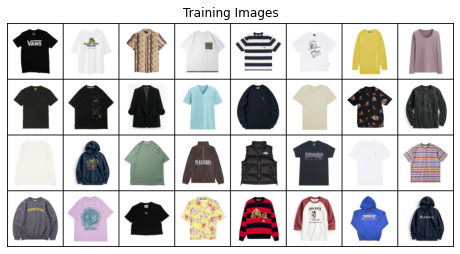

In [4]:
batch_images = next(iter(dataloader))[0]

real_image = np.transpose(vutils.make_grid(batch_images, padding=2, normalize=True).cpu().numpy(),(1,2,0))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(real_image)
plt.savefig('logs/real_images.png',bbox_inches='tight')

### Generator

In [5]:
GENERATOR_INPUT_SIZE = 100

In [6]:
Gnet = Generator(
    generator_input_size=GENERATOR_INPUT_SIZE,
    image_size=IMAGE_SIZE,
    image_channel=IMAGE_CHANNEL
).to(device)
print(Gnet)

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpl

In [7]:
summary(Gnet,input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13           [-1, 32, 64, 64]          32,768
      BatchNorm2d-14           [-1, 32,

### Discriminator

In [8]:
Dnet = Discriminator(
    image_channel=IMAGE_CHANNEL
).to(device)
print(Dnet)

Discriminator(
  (discriminator): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=Tr

In [9]:
summary(Dnet,input_size=(IMAGE_CHANNEL,IMAGE_SIZE,IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
       BatchNorm2d-4          [-1, 128, 32, 32]             256
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
       BatchNorm2d-7          [-1, 256, 16, 16]             512
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-10            [-1, 512, 8, 8]           1,024
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12            [-1, 512, 4, 4]       4,194,304
      BatchNorm2d-13            [-1, 512, 4, 4]           1,024
        LeakyReLU-14            [-1, 51

### Training

In [10]:
# custom weights initialization called on Generator and Discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Gnet.apply(weights_init)
Dnet.apply(weights_init)


Discriminator(
  (discriminator): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=Tr

In [11]:
# define loss and optimizer
# params were references from pyTorch tutorial

criterion = nn.BCELoss()
D_optimizer = optim.Adam(Dnet.parameters(), lr=2e-4, betas=(0.5, 0.999))
G_optimizer = optim.Adam(Gnet.parameters(), lr=2e-4, betas=(0.5, 0.999))


In [ ]:
EPOCHS = 45

# for visuliza in each epoch 
predefined_noise = torch.randn(BATCH_SIZE, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.


D_loss_list, G_loss_list = list(), list()

In [19]:
EPOCHS = 180
for epoch in range(1,EPOCHS+1):

    D_loss_over_epoch, G_loss_over_epoch = 0, 0
    pbar = tqdm(enumerate(dataloader),total=len(dataloader))

    for i, (real_images, _) in pbar:
        
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        
        # get real and fake (generated) image in this iter
        # be careful use number of images in this iter rather than batch_size, to avoid mismatch number of image in the last iter in each epoch
        real_images = real_images.to(device)
        real_image_labels = torch.full((real_images.shape[0],), real_label, dtype=torch.float, device=device)

        noise = torch.randn(real_images.shape[0], 100, 1, 1, device=device)
        fake_images = Gnet(noise)
        fake_image_labels = torch.full((real_images.shape[0],), fake_label, dtype=torch.float, device=device)


        # train Discriminator with real image
        D_output = Dnet(real_images).view(-1)
        D_real_image_loss = criterion(D_output, real_image_labels)
        D_real_image_loss.backward()

        # train Discriminator with fake image
        D_output = Dnet(fake_images).view(-1)
        D_fake_image_loss = criterion(D_output, fake_image_labels)
        D_fake_image_loss.backward(retain_graph=True)

        D_total_loss = D_real_image_loss + D_fake_image_loss
        D_loss_list.append(D_total_loss.item())
        D_optimizer.step()


        # train generator
        D_output = Dnet(fake_images).view(-1)
        G_loss = criterion(D_output, real_image_labels)
        G_loss_list.append(G_loss.item())
        G_loss.backward()
        G_optimizer.step()


        # update train description
        train_desc = f'Epoch [{epoch}/{EPOCHS}], D_Loss: {np.mean(D_loss_list):.4f}, G_Loss: {np.mean(G_loss_list):.4f}'
        pbar.set_description(desc = train_desc)

        # store generated image
        if i % 20 == 0 :
            fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True).cpu().detach().numpy(),(1,2,0))
            plt.imsave(f'logs/intermediate_training_images/epoch{epoch}_iter{i}.png', fake_images)

    # store weights
    torch.save(Gnet.state_dict(),'model/Gnet.pt')

Epoch [180/180], D_Loss: 0.4246, G_Loss: 5.2254: 100%|██████████| 83/83 [00:23<00:00,  3.58it/s]


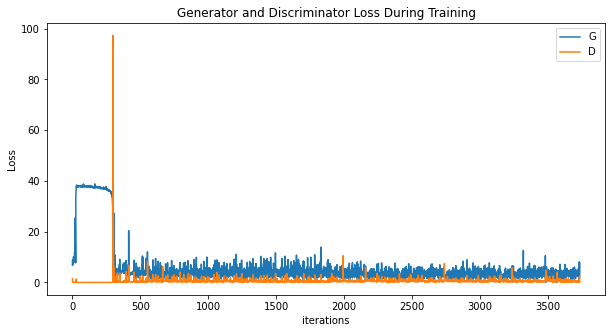

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss_list,label="G")
plt.plot(D_loss_list,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()